In [1]:
# [Cell 1] Imports & Config
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm，显示更友好
import os
import time
from torch_geometric.nn import GATConv, GCNConv, LayerNorm
from torch_geometric.data import DataLoader

# 1. 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Running on: {device}")

# 2. 增强版配置
CONFIG = {
    'batch_size': 1024,      # 保持稳健的 Batch Size
    'lr': 1e-3,              # 初始学习率
    'epochs': 2000,          # 训练轮数
    'hidden_dim': 256,       # [升级] 提升容量：128 -> 256
    'heads': 4,              # [新增] GAT 多头注意力
    'timesteps': 1000,
    'dropout': 0.1
}

# 绘图风格
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

🚀 Running on: cuda


In [2]:
# [Cell 2] Diffusion Components

class CosineNoiseScheduler(nn.Module):
    def __init__(self, num_timesteps, s=0.008):
        super().__init__()
        self.num_timesteps = num_timesteps
        
        # Cosine schedule calculation
        steps = num_timesteps + 1
        x = torch.linspace(0, num_timesteps, steps)
        alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        betas = torch.clip(betas, 0.0001, 0.9999)
        
        alphas = 1.0 - betas
        # Recalculate cumprod to be precise
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))

    def add_noise(self, x0, t, noise=None):
        if noise is None: noise = torch.randn_like(x0)
        # Reshape for broadcasting: [B] -> [B, 1]
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_1_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        xt = sqrt_alpha * x0 + sqrt_1_minus_alpha * noise
        return xt, noise

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

print("✅ Scheduler & Embedding defined.")

✅ Scheduler & Embedding defined.


In [3]:
# [Cell 3] GAT Model Architecture

class GAT_DenoiseNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=256, output_dim=1, heads=4):
        super().__init__()
        
        # 1. Encoders
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # Initial projection: Map [Noisy_V, P, Q] -> Hidden
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # 2. GAT Layers (with Residuals)
        # Note: GAT output dim is heads * out_channels. We verify dimensions carefully.
        self.conv1 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True)
        self.norm1 = LayerNorm(hidden_dim)
        
        # Layer 2
        self.conv2 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True)
        self.norm2 = LayerNorm(hidden_dim)
        
        # Layer 3
        self.conv3 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True)
        self.norm3 = LayerNorm(hidden_dim)
        
        # Output
        self.out_proj = nn.Linear(hidden_dim, output_dim)
        self.act = nn.SiLU()

    def forward_with_time_expand(self, x, t, batch_index, edge_index):
        """
        x: [N, 3] -> 包含 [Noisy_V, P, Q] !!!
        """
        # 1. Encoding
        h = self.input_proj(x)                  # [N, Hidden]
        t_emb = self.time_mlp(t)[batch_index]   # [N, Hidden]
        
        # 注入时间 (Time Injection) - Additive
        h = h + t_emb
        
        # 2. Layer 1
        h_in = h
        h = self.conv1(h, edge_index) # GAT
        h = self.norm1(h + h_in)      # Residual + Norm
        h = self.act(h)
        
        # 3. Layer 2 (Deep Time Injection)
        h = h + t_emb # Reinforce time
        h_in = h
        h = self.conv2(h, edge_index)
        h = self.norm2(h + h_in)
        h = self.act(h)
        
        # 4. Layer 3
        h = h + t_emb
        h_in = h
        h = self.conv3(h, edge_index)
        h = self.norm3(h + h_in)
        h = self.act(h)
        
        return self.out_proj(h)

print("✅ GAT Model defined.")

✅ GAT Model defined.


In [4]:
# [Cell 4] Data Loading
print("🔍 Loading Data...")
dataset = torch.load("../data/processed/ieee33_graph_data.pt", weights_only=False)
stats = torch.load("../data/processed/data_stats.pt", weights_only=False)

# Convert to Tensor on GPU
all_data_list = [d for d in dataset]
all_x_tensor = torch.stack([d.x for d in all_data_list]).to(device) # P, Q
all_y_tensor = torch.stack([d.y for d in all_data_list]).to(device) # V (Target)
num_samples = all_x_tensor.size(0)

# Static Topology
base_edge_index = all_data_list[0].edge_index.to(device)

def create_static_batch_topology(batch_size, base_edge_index, num_nodes=33):
    edge_index_batch = base_edge_index.unsqueeze(1).repeat(1, batch_size, 1)
    offset = torch.arange(0, batch_size, device=device).view(1, batch_size, 1) * num_nodes
    edge_index_batch += offset
    static_edge_index = edge_index_batch.view(2, -1)
    static_batch_idx = torch.arange(0, batch_size, device=device).view(-1, 1).repeat(1, num_nodes).view(-1)
    return static_edge_index, static_batch_idx

BATCH_SIZE = CONFIG['batch_size']
static_edge_index, static_batch_idx = create_static_batch_topology(BATCH_SIZE, base_edge_index)

🔍 Loading Data...


🚀 Starting Training (GAT + Cosine Schedule)...


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

✅ Training Complete.


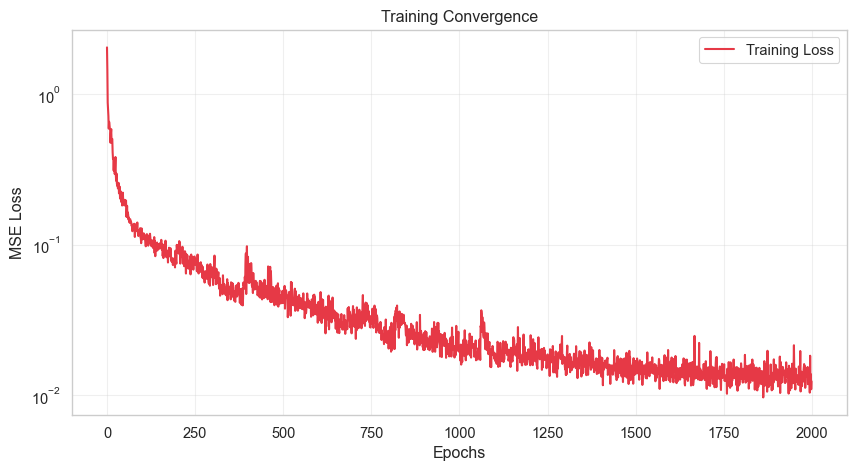

In [7]:
# [Cell 5] Training Loop
print("🚀 Starting Training (GAT + Cosine Schedule)...")

# Initialize
model = GAT_DenoiseNet(input_dim=3, hidden_dim=CONFIG['hidden_dim'], heads=CONFIG['heads']).to(device)
# [Change] 使用 Cosine Scheduler
scheduler = CosineNoiseScheduler(CONFIG['timesteps']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-5)

loss_history = []
model.train()

# Progress Bar
pbar = tqdm(range(CONFIG['epochs']), desc="Training")

for epoch in pbar:
    # 1. Sample Batch
    indices = torch.randint(0, num_samples, (BATCH_SIZE,), device=device)
    batch_cond = all_x_tensor[indices].view(-1, 2) # P, Q
    batch_x0 = all_y_tensor[indices].view(-1, 1)   # V
    
    # 2. Add Noise
    t = torch.randint(0, CONFIG['timesteps'], (BATCH_SIZE,), device=device)
    ts_nodes = t[static_batch_idx]
    xt, noise = scheduler.add_noise(batch_x0, ts_nodes)
    
    # 3. Model Forward
    # [Important] We concat xt and cond at the input channel
    # Input Dim = 1 (xt) + 2 (cond) = 3
    model_input = torch.cat([xt, batch_cond], dim=-1)
    
    noise_pred = model.forward_with_time_expand(
        x=model_input,
        t=t,
        batch_index=static_batch_idx,
        edge_index=static_edge_index
    )
    
    # 4. Loss
    loss = F.mse_loss(noise_pred, noise)
    
    optimizer.zero_grad()
    loss.backward()
    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    lr_scheduler.step()
    
    # Logging
    loss_val = loss.item()
    loss_history.append(loss_val)
    
    if epoch % 50 == 0:
        pbar.set_postfix({'Loss': f"{loss_val:.6f}", 'LR': f"{optimizer.param_groups[0]['lr']:.6f}"})

# Save
torch.save(model.state_dict(), "../models/gnn_diffusion_ieee33.pth")
print("✅ Training Complete.")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss', color='#E63946', linewidth=1.5)
plt.title('Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.yscale('log')

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

🔍 Starting Evaluation...


Sampling: 0it [00:00, ?it/s]

🎉 Validation RMSE: 0.0186 p.u.
🎉 Validation MAE:  0.0149 p.u.


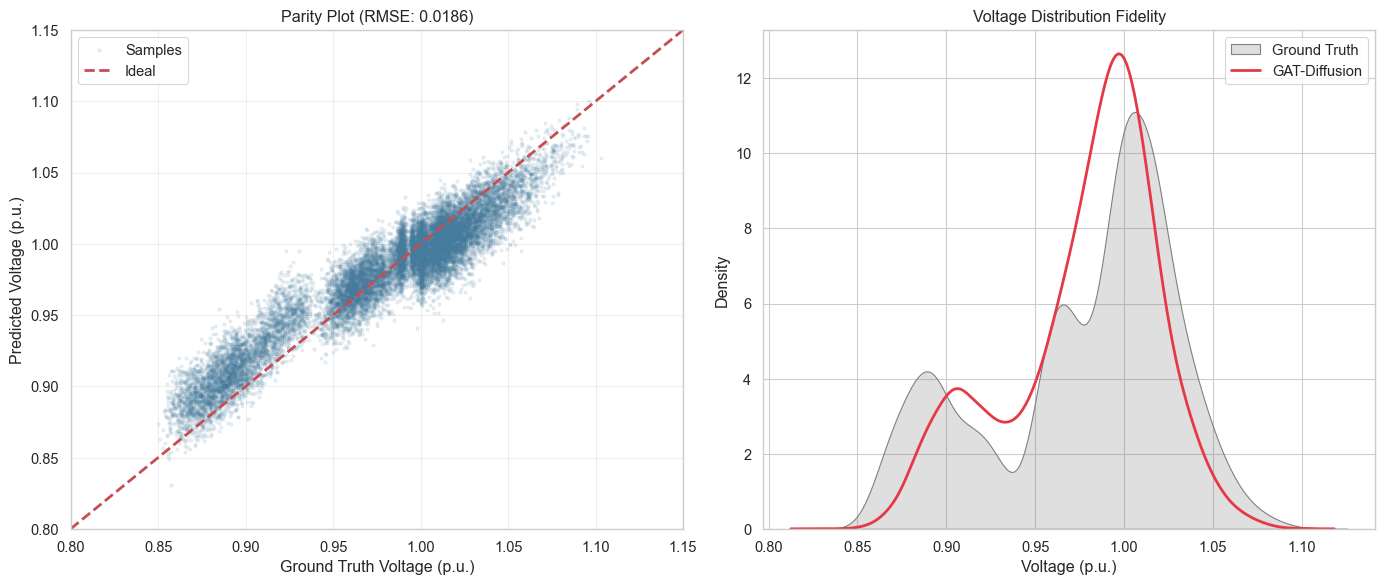

In [8]:
# [Cell 6] Evaluation
print("🔍 Starting Evaluation...")
model.eval()

# Test Set (First 500 samples)
test_size = 500
cond_test = all_x_tensor[:test_size].view(-1, 2)
gt_test_norm = all_y_tensor[:test_size].view(-1, 1)

# Test Topology
test_edge_index, test_batch_idx = create_static_batch_topology(test_size, base_edge_index)

# Start from pure noise
x = torch.randn(test_size * 33, 1, device=device)

with torch.no_grad():
    for i in tqdm(reversed(range(CONFIG['timesteps'])), desc="Sampling"):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        t_batch = t.repeat(test_size) # for embedding lookup
        
        # Construct Input: [x_t, P, Q]
        model_input = torch.cat([x, cond_test], dim=-1)
        
        pred_noise = model.forward_with_time_expand(
            x=model_input,
            t=t_batch,
            batch_index=test_batch_idx,
            edge_index=test_edge_index
        )
        
        # Scheduler Step (Cosine)
        alpha = scheduler.alphas_cumprod[i]
        beta = scheduler.betas[i]
        sqrt_1_minus_alpha = scheduler.sqrt_one_minus_alphas_cumprod[i]
        
        # Mean
        coeff1 = 1 / torch.sqrt(1 - beta)
        coeff2 = beta / sqrt_1_minus_alpha
        mean = coeff1 * (x - coeff2 * pred_noise)
        
        # Clamp for stability
        mean = torch.clamp(mean, -3.0, 3.0)
        
        if i > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta)
            x = mean + sigma * noise
        else:
            x = mean

# Denormalize
v_min = stats['v_min']
v_max = stats['v_max']

gen_v = (x.cpu().numpy().flatten() + 1) / 2 * (v_max - v_min) + v_min
gt_v = (gt_test_norm.cpu().numpy().flatten() + 1) / 2 * (v_max - v_min) + v_min

# Metrics
rmse = np.sqrt(np.mean((gen_v - gt_v)**2))
mae = np.mean(np.abs(gen_v - gt_v))
print(f"🎉 Validation RMSE: {rmse:.4f} p.u.")
print(f"🎉 Validation MAE:  {mae:.4f} p.u.")

# Plots
plt.figure(figsize=(14, 6))

# 1. Parity Plot
plt.subplot(1, 2, 1)
plt.scatter(gt_v, gen_v, alpha=0.1, s=5, color='#457B9D', label='Samples')
min_val, max_val = 0.80, 1.15
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Ideal")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.title(f"Parity Plot (RMSE: {rmse:.4f})")
plt.xlabel("Ground Truth Voltage (p.u.)")
plt.ylabel("Predicted Voltage (p.u.)")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Distribution
plt.subplot(1, 2, 2)
sns.kdeplot(gt_v, fill=True, color='gray', label='Ground Truth')
sns.kdeplot(gen_v, color='#E63946', linewidth=2, label='GAT-Diffusion')
plt.title("Voltage Distribution Fidelity")
plt.xlabel("Voltage (p.u.)")
plt.legend()

plt.tight_layout()
plt.show()